<a href="https://colab.research.google.com/github/OwenGN/TIM147/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Analyzing the LinkedIn Job Postings Data collected over 2 separate days Months apart in 2023. The Data was posted on Kaggle.

The Goal of the Project is to analyze the data for trends that would prepare UCSC undergraduate students particularly those in the Technology and Information Management, Applied Mathematics and Computer Science majors for employability.

In [ ]:
import pandas as pd
from collections import Counter
import re
from nltk import bigrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
!pip install rake-nltk
import nltk
from rake_nltk import Rake
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#df is the DataFrame with LinkedIn job postings
df = pd.read_csv("job_postings.csv")

In [ ]:
'''!pip install nltk
import nltk
nltk.download('punkt')


In [ ]:
df.describe()

,job_id,company_id,max_salary,med_salary,min_salary,applies,remote_allowed,sponsored
count,3.324600e+04,3.259200e+04,1.111100e+04,2241.000000,11111.000000,16238.000000,4802.0,33246.000000
mean,3.723675e+09,1.145638e+07,8.880883e+04,32426.170598,62650.128421,18.895246,1.0,0.244150
std,9.264310e+07,2.391219e+07,8.764506e+04,76860.422528,58732.644143,49.059029,0.0,0.429588
min,3.958427e+06,1.009000e+03,1.000000e+01,0.000000,7.250000,1.000000,1.0,0.000000
25%,3.697367e+09,1.840100e+04,5.100000e+01,18.780000,40.945000,2.000000,1.0,0.000000
50%,3.749345e+09,4.687820e+05,8.392800e+04,29.000000,62128.000000,5.000000,1.0,0.000000
75%,3.756905e+09,9.222480e+06,1.400000e+05,42746.000000,100000.000000,16.000000,1.0,0.000000
max,3.757940e+09,1.011741e+08,1.300000e+06,998426.000000,800000.000000,1615.000000,1.0,1.000000


Filter the data for STEM jobs that require a Bachelors degree as these would have the target students as the best candidates.

This is done using keyword searches in the description, title and skills description columns of the data

In [ ]:
# Filter for STEM jobs
stem_keywords = [
    'science', 'scientist', 'research', 'laboratory', 'biology', 'chemistry', 'physics',
    'technology', 'IT', 'information technology', 'software', 'developer', 'programming', 'coding', 'web development',
    'engineering', 'mechanical', 'electrical', 'civil', 'structural', 'aerospace', 'chemical', 'environmental',
    'mathematics', 'mathematician', 'data science', 'statistics', 'quantitative', 'analytics', 'actuary',
    'computer science', 'computer engineering', 'machine learning', 'artificial intelligence',
    'data analysis', 'cybersecurity', 'network engineering', 'database management',
    'biomedical', 'bioinformatics', 'medical technology', 'health informatics', 'healthcare IT', 'medical imaging',
    'renewable energy', 'solar', 'wind', 'sustainable energy', 'environmental engineering', 'robotics', 'automation', 'robotic engineering',
    'space', 'astronomy', 'astrophysics', 'aerospace engineering', 'stem education', 'education technology', 'stem outreach',
    'telecommunications', 'network engineering', 'wireless communication', 'nanotechnology', 'nanoscience', 'materials science', 'metallurgy',
    'quantum computing', 'quantum physics','analysist','analysis']
stem_jobs = df[df['description'].str.contains('|'.join(stem_keywords), case=False, na=False) |
               df['title'].str.contains('|'.join(stem_keywords), case=False, na=False)]
# Filter for jobs that require a bachelor's degree
bachelors_degree_jobs = stem_jobs[stem_jobs['description'].str.contains("bachelor's degree", case=False, na=False) | stem_jobs['skills_desc'].str.contains
 ("bachelor's degree", case=False)]

# Display the filtered DataFrame
#bachelors_degree_jobs


Filter for Entry Level jobs as the students in question are right out of college with little to no industry experience.

This is done by excluding the data with non-entry level key words such as manager, senior, director and executive

In [ ]:
Non_Entry=['manager','senior','director','executive','sr','lead','leader','supervisor','sales','chief','president','vp','head','principal','mid-senior','controller','nurse','Mid-senior']
Entry_level_jobs = bachelors_degree_jobs[~bachelors_degree_jobs['title'].str.contains('|'.join(Non_Entry), case=False, na=False) & ~bachelors_degree_jobs['formatted_experience_level'].str.contains('|'.join(stem_keywords), case=False, na=False)]
#Entry_level_jobs

We employ the TF-IDF model

In [ ]:
'''corpus = Entry_level_jobs['description'].astype(str)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
num_keywords = 5
keywords = {}
for i, row in enumerate(Entry_level_jobs.iterrows()):
    idx, _ = row
    similar_indices = cosine_similarities[i].argsort()[:-num_keywords-1:-1]
    keywords[idx] = [(vectorizer.get_feature_names_out()[s], cosine_similarities[i][s]) for
                     s in similar_indices]
for idx, kw in keywords.items():
    print(f"Document {idx}: {kw}")

In [ ]:
'''combined_text = ' '.join(Entry_level_jobs['description'])
custom_stopwords = set([
    'job', 'position', 'experience', 'role', 'responsibilities', 'requirements',
    'qualifications', 'skills', 'company', 'description', 'apply', 'application',
    'responsibilities', 'qualifications', 'requirements', 'apply', 'application',
    'apply now', 'click', 'apply', 'please', 'click apply', 'candidates', 'apply online',
    'send', 'resume', 'cover letter', 'equal opportunity', 'employer', 'employment',
    'opportunity', 'work', 'working', 'salary', 'benefits', 'perks', 'full-time', 'part-time',
    'contract', 'remote', 'location', 'years of experience', 'degree', 'education', 'apply button',
    'responsibilities include', 'qualifications include', 'requirements include', 'successful candidate',
    'successful candidates', 'successful applicant', 'successful applicants', 'competitive salary',
    'job type', 'job location', 'deadline', 'closing date', 'please note', 'interviews will be conducted',
    'successful candidates will be contacted', 'successful applicant will be contacted',
    'apply via', 'desired skills', 'ideal candidate', 'equal employment opportunity employer',
    'apply now button', 'email your resume', 'cover letter', 'please submit your application',
    'competitive salary', 'competitive compensation', 'excellent benefits', 'fast-paced environment',
    'self-motivated', 'team player', 'equal opportunity employer', 'apply for this position',
    'apply to this job', 'click here to apply', 'employment type', 'salary range',
    'competitive salary', 'great benefits', 'perks include', 'successful candidates will',
    'successful applicant will', 'successful candidates will be', 'successful applicant will be',
    'successful candidate will', 'successful candidate will be', 'successful candidate will have',
    'successful candidate will possess', 'ideal candidate will have', 'ideal candidate will possess',
    'ideal candidate possesses', 'apply now to be considered', 'join our team', 'successful candidates must',
    'successful applicant must', 'successful candidate should', 'successful applicant should'
])
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + list(custom_stopwords))
tfidf_matrix = vectorizer.fit_transform(Entry_level_jobs['description'])

feature_names = vectorizer.get_feature_names_out()
top_keywords = [feature_names[i] for i in tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:10]]

r = Rake(stopwords=stopwords.words('english') + list(custom_stopwords))
r.extract_keywords_from_text(combined_text)
rake_keywords = r.get_ranked_phrases()[:10]

print("Top Keywords (TF-IDF):", top_keywords)
top_keywords_array = top_keywords[0][0]
array_length = len(top_keywords_array)
print('lenght: ', array_length)
print("Rake Keywords:", rake_keywords)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['applicant', 'applicants', 'button', 'candidate', 'closing', 'compensation', 'competitive', 'conducted', 'considered', 'contacted', 'cover', 'date', 'desired', 'email', 'environment', 'equal', 'excellent', 'fast', 'full', 'great', 'ideal', 'include', 'interviews', 'join', 'letter', 'motivated', 'must', 'note', 'online', 'paced', 'part', 'player', 'possess', 'possesses', 'range', 'self', 'submit', 'successful', 'team', 'time', 'type', 'via', 'years'] not in stop_words.
  warnings.warn(


Top Keywords (TF-IDF): [array([['data', 'business', 'team', ..., 'hiea', 'realview', 'provation']],
      dtype=object)]
lenght:  27826
Rake Keywords: ['decision makingcritical thinkingtime managementinstructingactive listeningactive learningquality control analysisequipment selection abilities written expressionoral expressionwritten comprehensionoral comprehensiongross body coordinationdeductive reasoninginductive reasoningstaminastatic strength tools', 'matchingdental insuranceflexible spending accounthealth insurancehealth savings accountlife insurancepaid time offparental leaveprofessional development assistancetuition reimbursementvision insurance qualified applicants', 'upcoming project westside multimodal improvements studytv highway transit studycity travel demand model updatetransportation systems plan updatetransportation planning', 'package pension plan 401k matchemployee stock purchase plantuition reimbursementdisability insurancemedical insurancedental insurancevision ins

In [ ]:
company_counts = Counter(Entry_level_jobs['company_id'])
most_common_company = company_counts.most_common(15)
most_common_company

[(2646.0, 55),
 (11056.0, 30),
 (1441.0, 27),
 (70696.0, 23),
 (1403.0, 21),
 (3671.0, 19),
 (1586.0, 16),
 (10420321.0, 15),
 (1103.0, 14),
 (5235.0, 12),
 (777243.0, 10),
 (2396310.0, 9),
 (18860134.0, 9),
 (3476.0, 9),
 (4674.0, 9)]

The above analysis has Google(ID: 1441) as one of the top companies in terms of vacancies posted, Booz Allen as well(ID: 1403), Amazon (ID:1586), Exelon(ID:4674)

Company analysis was disrupted by the multiple recruiter companies that dominated the data.

A seperate dataframe is created where TIM, AM an CS are exclusively mentioned as Target major which would be expected to give them an edge over the other applicants.

In [ ]:
TIM_AM_CS=['Technology and Information Management','Applied Mathematics','Computer Science']
TIM_AM_CS_df=Entry_level_jobs[Entry_level_jobs['description'].str.contains('|'.join(TIM_AM_CS), case=False, na=False) | Entry_level_jobs['skills_desc'].str.contains('|'. join(TIM_AM_CS), case=False, na=False)]
TIM_AM_CS_df

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,job_posting_url,formatted_experience_level,skills_desc,sponsored,work_type,currency,compensation_type
170,3757920617,54350022.0,Full Stack Developer - API Integrations,Full Stack Developer - API IntegrationsJob Des...,NaN,NaN,NaN,NaN,Full-time,United States,4.0,1.0,https://www.linkedin.com/jobs/view/3757920617/...,NaN,NaN,0,FULL_TIME,NaN,NaN
176,3757920135,11568.0,ISD Analyst II-ID & Access Mgmt,"Overview\n\nTo compile, research, analyze and ...",NaN,NaN,NaN,NaN,Full-time,"Pensacola, FL",NaN,NaN,https://www.linkedin.com/jobs/view/3757920135/...,Entry level,NaN,0,FULL_TIME,NaN,NaN
227,3757917481,11568.0,ISD Analyst II-ID & Access Mgmt,"Overview\n\nTo compile, research, analyze and ...",NaN,NaN,NaN,NaN,Full-time,"Minneapolis–Saint Paul, WI",NaN,NaN,https://www.linkedin.com/jobs/view/3757917481/...,Entry level,NaN,0,FULL_TIME,NaN,NaN
653,3757903602,79098.0,Data Warehouse Engineer,Are you ready to embark on an exciting journey...,124000.0,NaN,114000.0,YEARLY,Contract,"St Louis, MO",7.0,1.0,https://www.linkedin.com/jobs/view/3757903602/...,Entry level,NaN,0,CONTRACT,USD,BASE_SALARY
751,3757788824,98795204.0,Machine Learning Engineer,Company DescriptionWe are a startup that provi...,NaN,NaN,NaN,NaN,Full-time,"San Jose, CA",NaN,NaN,https://www.linkedin.com/jobs/view/3757788824/...,NaN,NaN,0,FULL_TIME,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32448,3693044920,7973087.0,Splunk Developer,Splunk Developer Location: New Jersey/ Atlanta...,NaN,NaN,NaN,NaN,Contract,"Irving, TX",NaN,NaN,https://www.linkedin.com/jobs/view/3693044920/...,NaN,NaN,0,CONTRACT,NaN,NaN
32505,3693044658,16263152.0,Hiring for Cloud Administrator,Job Summary:The Medefy Cloud Administrator is ...,85000.0,NaN,65000.0,YEARLY,Full-time,"Tulsa, OK",25.0,NaN,https://www.linkedin.com/jobs/view/3693044658/...,NaN,NaN,0,FULL_TIME,USD,BASE_SALARY
32559,3693044448,1286891.0,Business Analyst - W2 Only,Role - Business Analyst - Mobile Location - Lo...,NaN,NaN,NaN,NaN,Contract,"Louisville, KY",NaN,NaN,https://www.linkedin.com/jobs/view/3693044448/...,NaN,NaN,0,CONTRACT,NaN,NaN
32591,3693044317,4787.0,PL/SQL Developer,** Please note that this role is not available...,65.0,NaN,53.0,HOURLY,Contract,"Houston, TX",NaN,NaN,https://www.linkedin.com/jobs/view/3693044317/...,Associate,NaN,0,CONTRACT,USD,BASE_SALARY


In [ ]:
'''combined_text = ' '.join(TIM_AM_CS_df['description'])
custom_stopwords = set([
    'job', 'position', 'experience', 'role', 'responsibilities', 'requirements',
    'qualifications', 'skills', 'company', 'description', 'apply', 'application',
    'responsibilities', 'qualifications', 'requirements', 'apply', 'application',
    'apply now', 'click', 'apply', 'please', 'click apply', 'candidates', 'apply online',
    'send', 'resume', 'cover letter', 'equal opportunity', 'employer', 'employment',
    'opportunity', 'work', 'working', 'salary', 'benefits', 'perks', 'full-time', 'part-time',
    'contract', 'remote', 'location', 'years of experience', 'degree', 'education', 'apply button',
    'responsibilities include', 'qualifications include', 'requirements include', 'successful candidate',
    'successful candidates', 'successful applicant', 'successful applicants', 'competitive salary',
    'job type', 'job location', 'deadline', 'closing date', 'please note', 'interviews will be conducted',
    'successful candidates will be contacted', 'successful applicant will be contacted',
    'apply via', 'desired skills', 'ideal candidate', 'equal employment opportunity employer',
    'apply now button', 'email your resume', 'cover letter', 'please submit your application',
    'competitive salary', 'competitive compensation', 'excellent benefits', 'fast-paced environment',
    'self-motivated', 'team player', 'equal opportunity employer', 'apply for this position',
    'apply to this job', 'click here to apply', 'employment type', 'salary range',
    'competitive salary', 'great benefits', 'perks include', 'successful candidates will',
    'successful applicant will', 'successful candidates will be', 'successful applicant will be',
    'successful candidate will', 'successful candidate will be', 'successful candidate will have',
    'successful candidate will possess', 'ideal candidate will have', 'ideal candidate will possess',
    'ideal candidate possesses', 'apply now to be considered', 'join our team', 'successful candidates must',
    'successful applicant must', 'successful candidate should', 'successful applicant should'
])
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + list(custom_stopwords))
tfidf_matrix = vectorizer.fit_transform(TIM_AM_CS_df['description'])

feature_names = vectorizer.get_feature_names_out()
top_keywords = [feature_names[i] for i in tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:10]]

r = Rake(stopwords=stopwords.words('english') + list(custom_stopwords))
r.extract_keywords_from_text(combined_text)
rake_keywords = r.get_ranked_phrases()[:10]

print("Top Keywords (TF-IDF):", top_keywords)
top_keywords_array = top_keywords[0][0]
array_length = len(top_keywords_array)
print('lenght: ', array_length)
print("Rake Keywords:", rake_keywords)

In [ ]:
'''key_phrases = [
    'accounting principles', 'financial analysis', 'budgeting and cost control',
    'financial management systems', 'Excel','spreadsheets', 'inventory management',
    'valuation', 'analytical skills', 'problem-solving skills', 'Strong communication',
    'interpersonal skills', 'independent work', 'financial reporting', 'data analysis',
    'queries', 'visualization', ' R ', 'Python', 'Analytical programming', ' SAS ', ' SQL ',
    'data manipulation', 'statistical software', 'Azure', 'cloud-based environments',
    'Power BI', 'Tableau', 'Splunk', ' AWS ', 'process improvement', 'optimization',
    'business process modeling', 'project management', 'survey research', 'statistics',
    'dashboarding', 'visualization', 'statistical analysis', 'predictive modeling',
    'qualitative and quantitative research', 'data extraction and manipulation',
    ' C ', 'C#', 'C++', 'Linux', 'data structures', 'algorithms', 'DevOps', ' GO ', 'Ruby',
    'Java Script', 'full software development life cycle', 'PHP', 'TensorFlow', 'PyTorch',
    'Matlab', 'Simulink', 'debugging', 'Unix'
]


# Load a pre-trained sentence embedding model (e.g., 'paraphrase-MiniLM-L6-v2')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create a new column to store detected skills
TIM_AM_CS_df['detected_skills'] = ""

# Process each potential skill
for skill in key_phrases:
    # Encode the skill
    skill_embedding = model.encode(skill, convert_to_tensor=True)

    # Process each job description
    for index, row in df.iterrows():
        job_description = row['description']

        # Encode the job description
        job_embedding = model.encode(job_description, convert_to_tensor=True)

        # Calculate cosine similarity
        similarity = util.pytorch_cos_sim(skill_embedding, job_embedding).item()

        # Set a similarity threshold (you can adjust this)
        similarity_threshold = 0.8

        # Check if the skill is present in the job description
        if similarity > similarity_threshold:
            # Append the detected skill to the 'detected_skills' column
            TIM_AM_CS_df.at[index, 'detected_skills'] += f"{skill}, "

# Remove trailing commas


TIM_AM_CS_df['detected_skills'] = TIM_AM_CS_df['detected_skills'].str.rstrip(', ')

In [ ]:
'''tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
for index, row in TIM_AM_CS_df.iterrows():
    job_description = row['description']

    # Tokenize and encode the job description
    inputs = tokenizer(job_description, return_tensors='pt', max_length=512, truncation=True)

    # Obtain BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract BERT embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    #print(embeddings[:10])


A word count is run on the title column to retrieve the most common words in the titles available

In [ ]:
word_counts_title = Counter(' '.join(Entry_level_jobs['title']).split()).most_common(100)
word_counts_title

[('Engineer', 340),
 ('-', 338),
 ('Analyst', 225),
 ('Specialist', 191),
 ('Staff', 102),
 ('Coordinator', 89),
 ('Business', 84),
 ('Accountant', 74),
 ('and', 74),
 ('Associate', 72),
 ('Software', 67),
 ('Developer', 62),
 ('Data', 61),
 ('II', 58),
 ('I', 53),
 ('&', 51),
 ('Support', 51),
 ('Pharmacist', 48),
 ('Project', 47),
 ('Assistant', 46),
 ('(USA)', 44),
 ('Marketing', 44),
 ('Bonus', 42),
 ('Consultant', 42),
 ('Cloud', 40),
 ('Security', 39),
 ('Development', 38),
 ('Tax', 38),
 ('Administrator', 37),
 ('Product', 37),
 ('Architect', 36),
 ('Designer', 35),
 ('Technical', 33),
 ('Design', 33),
 ('Management', 32),
 ('Service', 31),
 ('Technician', 30),
 ('Customer', 29),
 ('Financial', 29),
 ('Quality', 28),
 ('Sign', 28),
 ('Network', 28),
 ('Operations', 27),
 ('2024', 27),
 ('Representative', 26),
 ('Human', 26),
 ('Systems', 26),
 ('Field', 26),
 ('Engineer,', 25),
 ('Advisor', 25),
 ('IT', 24),
 ('Research', 24),
 ('System', 23),
 ('Professional', 23),
 ('(Job', 23

The word count is run for the smaller data frame of the description explicitly mentioning our majors of interest.

In [ ]:
word_counts_title_TAC = Counter(' '.join(TIM_AM_CS_df['title']).split()).most_common(100)
word_counts_title_TAC

[('Engineer', 115),
 ('Analyst', 60),
 ('Software', 56),
 ('Developer', 54),
 ('-', 45),
 ('Cloud', 38),
 ('Data', 31),
 ('Architect', 25),
 ('Business', 22),
 ('Engineer,', 20),
 ('Security', 20),
 ('Network', 19),
 ('Google', 18),
 ('IT', 16),
 ('Administrator', 14),
 ('Application', 14),
 ('Specialist', 13),
 ('Technical', 12),
 ('Product', 12),
 ('and', 12),
 ('Development', 12),
 ('Machine', 11),
 ('II', 11),
 ('Staff', 11),
 ('Learning', 10),
 ('Web', 10),
 ('Support', 9),
 ('Solution', 8),
 ('System', 7),
 ('Solutions', 7),
 ('|', 7),
 ('Systems', 7),
 ('Associate', 7),
 ('Consultant', 7),
 ('TX', 7),
 ('Full', 6),
 ('&', 6),
 ('Quality', 6),
 ('Infrastructure', 6),
 ('III', 6),
 ('Owner', 6),
 ('Analytics', 6),
 ('Customer', 6),
 ('Stack', 5),
 ('Database', 5),
 ('DevOps', 5),
 ('Assurance', 5),
 ('Java', 5),
 ('Test', 5),
 ('W2', 5),
 ('Technology', 5),
 ('Azure', 5),
 ('Telecom', 5),
 ('Fulfillment', 5),
 ('IAM', 4),
 ('Management', 4),
 ('Analyst,', 4),
 ('Global', 4),
 ('Co

We try to find an index of the most relevant skills but with limited knowledge on how. We do a manual search with a sample of the data which we base to get key skills and attributes. We use said list of skills to check the frequency through out the data base so as to rank the most relevant ones and below shows the ranking.

In [ ]:
key_phrases = [
    'accounting principles', 'financial analysis', 'budgeting and cost control',
    'financial management systems', 'MS Excel','spreadsheets', 'inventory management',
    'valuation', 'analytical skills', 'problem-solving skills', 'Strong communication',
    'interpersonal skills', 'independent work', 'financial reporting', 'data analysis',
    'queries', 'visualization', ' R ', 'Python', 'Analytical programming', ' SAS ', ' SQL ',
    'data manipulation', 'statistical software', 'Azure', 'cloud-based environments',
    'Power BI', 'Tableau', 'Splunk', ' AWS ', 'process improvement', 'optimization',
    'business process modeling', 'project management', 'survey research', 'statistics',
    'dashboarding', 'visualization', 'statistical analysis', 'predictive modeling',
    'qualitative and quantitative research', 'data extraction and manipulation',
    ' C ', 'C#', 'C++', 'Linux', 'data structures', 'algorithms', 'DevOps', ' GO ', 'Ruby',
    'Java Script', 'full software development life cycle', 'PHP', 'TensorFlow', 'PyTorch',
    'Matlab', 'Simulink', 'debugging', 'Unix'
]
counts_per_key_phrase = {key_phrase: Entry_level_jobs['description'].str.count(re.escape(key_phrase), flags=re.IGNORECASE).sum() for key_phrase in key_phrases}
counts_per_key_phrase = sorted(counts_per_key_phrase.items(), key=lambda x: x[1], reverse=True)
len(key_phrases)

60

In [ ]:
def find_skillz(description):
    found_skillz = [skill for skill in key_phrases if skill.lower() in description.lower()]
    return ', '.join(found_skillz)

TIM_AM_CS_df['Skillz'] = TIM_AM_CS_df['description'].apply(find_skillz)

TIM_AM_CS_df

<ipython-input-117-5cf808edb2cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TIM_AM_CS_df['Skillz'] = TIM_AM_CS_df['description'].apply(find_skillz)


,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,job_posting_url,formatted_experience_level,skills_desc,sponsored,work_type,currency,compensation_type,Skillz
170,3757920617,54350022.0,Full Stack Developer - API Integrations,Full Stack Developer - API IntegrationsJob Des...,NaN,NaN,NaN,NaN,Full-time,United States,4.0,1.0,https://www.linkedin.com/jobs/view/3757920617/...,NaN,NaN,0,FULL_TIME,NaN,NaN,"problem-solving skills, Python, Azure, algorithms"
176,3757920135,11568.0,ISD Analyst II-ID & Access Mgmt,"Overview\n\nTo compile, research, analyze and ...",NaN,NaN,NaN,NaN,Full-time,"Pensacola, FL",NaN,NaN,https://www.linkedin.com/jobs/view/3757920135/...,Entry level,NaN,0,FULL_TIME,NaN,NaN,statistics
227,3757917481,11568.0,ISD Analyst II-ID & Access Mgmt,"Overview\n\nTo compile, research, analyze and ...",NaN,NaN,NaN,NaN,Full-time,"Minneapolis–Saint Paul, WI",NaN,NaN,https://www.linkedin.com/jobs/view/3757917481/...,Entry level,NaN,0,FULL_TIME,NaN,NaN,statistics
653,3757903602,79098.0,Data Warehouse Engineer,Are you ready to embark on an exciting journey...,124000.0,NaN,114000.0,YEARLY,Contract,"St Louis, MO",7.0,1.0,https://www.linkedin.com/jobs/view/3757903602/...,Entry level,NaN,0,CONTRACT,USD,BASE_SALARY,"visualization, SQL , Azure, visualization, da..."
751,3757788824,98795204.0,Machine Learning Engineer,Company DescriptionWe are a startup that provi...,NaN,NaN,NaN,NaN,Full-time,"San Jose, CA",NaN,NaN,https://www.linkedin.com/jobs/view/3757788824/...,NaN,NaN,0,FULL_TIME,NaN,NaN,"problem-solving skills, Python, statistics, Py..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32448,3693044920,7973087.0,Splunk Developer,Splunk Developer Location: New Jersey/ Atlanta...,NaN,NaN,NaN,NaN,Contract,"Irving, TX",NaN,NaN,https://www.linkedin.com/jobs/view/3693044920/...,NaN,NaN,0,CONTRACT,NaN,NaN,"interpersonal skills, Python, Splunk, Linux, Unix"
32505,3693044658,16263152.0,Hiring for Cloud Administrator,Job Summary:The Medefy Cloud Administrator is ...,85000.0,NaN,65000.0,YEARLY,Full-time,"Tulsa, OK",25.0,NaN,https://www.linkedin.com/jobs/view/3693044658/...,NaN,NaN,0,FULL_TIME,USD,BASE_SALARY,"problem-solving skills, Azure, DevOps"
32559,3693044448,1286891.0,Business Analyst - W2 Only,Role - Business Analyst - Mobile Location - Lo...,NaN,NaN,NaN,NaN,Contract,"Louisville, KY",NaN,NaN,https://www.linkedin.com/jobs/view/3693044448/...,NaN,NaN,0,CONTRACT,NaN,NaN,optimization
32591,3693044317,4787.0,PL/SQL Developer,** Please note that this role is not available...,65.0,NaN,53.0,HOURLY,Contract,"Houston, TX",NaN,NaN,https://www.linkedin.com/jobs/view/3693044317/...,Associate,NaN,0,CONTRACT,USD,BASE_SALARY,"queries, SQL , optimization, Linux, Unix"


To analyze the prospective salaries, the job postings without any salary information are exluded. We go step by step for the pay period type. For the yearly pay_period, the salaries represent the pay over a year. We used the med_salary column as the standard column so for job_postings without a med_salary, we go the average of the max and min to estimate the med.

For the Hourly payperiod, the same applied but with an additional step of multiplying the med_salary by 2080(40*52) to represent the typical 40 hour week and 52 weeks in a year.

For the Monthly pay_period, the same applies but multiplying by 12 instead to count for the 12 months in the year

**SALARY FILTERED**

In [ ]:
# Filter rows based on conditions
filtered_Y_df = Entry_level_jobs[(Entry_level_jobs['pay_period'] == 'YEARLY') & (Entry_level_jobs[['min_salary', 'max_salary', 'med_salary']].notna().any(axis=1))]
filtered_Y_df['med_salary'] = filtered_Y_df.apply(lambda row: row[['min_salary', 'max_salary']].mean() if pd.isna(row['med_salary']) else row['med_salary'], axis=1)
filtered_H_df = Entry_level_jobs[(Entry_level_jobs['pay_period'] == 'HOURLY') & (Entry_level_jobs[['min_salary', 'max_salary', 'med_salary']].notna().any(axis=1))]
filtered_H_df['med_salary'] = filtered_H_df.apply(lambda row: row[['min_salary', 'max_salary']].mean() if pd.isna(row['med_salary']) else row['med_salary'], axis=1)
filtered_H_df['med_salary'] = filtered_H_df['med_salary'] * 2080
filtered_M_df = Entry_level_jobs[(Entry_level_jobs['pay_period'] == 'MONTHLY') & (Entry_level_jobs[['min_salary', 'max_salary', 'med_salary']].notna().any(axis=1))]
filtered_M_df['med_salary'] = filtered_Y_df.apply(lambda row: row[['min_salary', 'max_salary']].mean() if pd.isna(row['med_salary']) else row['med_salary'], axis=1)
filtered_H_df['med_salary'] = filtered_H_df['med_salary'] * 12
Salary_df = pd.concat([filtered_H_df, filtered_M_df, filtered_Y_df],ignore_index=True)
filtered_Y_df = filtered_Y_df[filtered_Y_df['formatted_work_type'] == 'Full-time']
filtered_Y_df = filtered_Y_df.sort_values(by='med_salary',ascending=False)
#filtered_Y_df

Did the same for the data frame with exclusive mention of TIM, AM or CS, only considering the YEARLY pay_period

In [ ]:
filtered_Y_T_df = TIM_AM_CS_df[(Entry_level_jobs['pay_period'] == 'YEARLY') & (Entry_level_jobs[['min_salary', 'max_salary', 'med_salary']].notna().any(axis=1))]
filtered_Y_T_df['med_salary'] = filtered_Y_T_df.apply(lambda row: row[['min_salary', 'max_salary']].mean() if pd.isna(row['med_salary']) else row['med_salary'], axis=1)
filtered_Y_T_df = filtered_Y_T_df[filtered_Y_T_df['formatted_work_type'] == 'Full-time']
filtered_Y_T_df = filtered_Y_T_df.sort_values(by='med_salary',ascending=False)
filtered_Y_T_df

<ipython-input-9-4be2afa6706a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_Y_T_df = TIM_AM_CS_df[(Entry_level_jobs['pay_period'] == 'YEARLY') & (Entry_level_jobs[['min_salary', 'max_salary', 'med_salary']].notna().any(axis=1))]
<ipython-input-9-4be2afa6706a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Y_T_df['med_salary'] = filtered_Y_T_df.apply(lambda row: row[['min_salary', 'max_salary']].mean() if pd.isna(row['med_salary']) else row['med_salary'], axis=1)


,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,applies,remote_allowed,job_posting_url,formatted_experience_level,skills_desc,sponsored,work_type,currency,compensation_type,Skillz
11375,3755592226,10629072.0,RISC-V Embedded Software Engineer,Tenstorrent is leading the industry on cutting...,500000.0,300000.0,100000.0,YEARLY,Full-time,"Santa Clara, CA",18.0,1.0,https://www.linkedin.com/jobs/view/3755592226/...,Entry level,NaN,0,FULL_TIME,USD,BASE_SALARY,"Python, C++, Linux"
22758,3699076758,1441.0,"Staff Connectivity Security Researcher, Google...",Note: By applying to this position you will ha...,283000.0,234000.0,185000.0,YEARLY,Full-time,"Atlanta, GA",1.0,NaN,https://www.linkedin.com/jobs/view/3699076758/...,NaN,NaN,0,FULL_TIME,USD,BASE_SALARY,
22728,3699077714,1441.0,"Staff Connectivity Security Researcher, Google...",Note: By applying to this position you will ha...,283000.0,234000.0,185000.0,YEARLY,Full-time,"Chicago, IL",NaN,NaN,https://www.linkedin.com/jobs/view/3699077714/...,NaN,NaN,1,FULL_TIME,USD,BASE_SALARY,
22727,3699077715,1441.0,"Staff Connectivity Security Researcher, Google...",Note: By applying to this position you will ha...,283000.0,234000.0,185000.0,YEARLY,Full-time,"San Diego, CA",NaN,NaN,https://www.linkedin.com/jobs/view/3699077715/...,NaN,NaN,0,FULL_TIME,USD,BASE_SALARY,
22709,3699078495,1441.0,"Staff Connectivity Security Researcher, Google...",Note: By applying to this position you will ha...,283000.0,234000.0,185000.0,YEARLY,Full-time,"Mountain View, CA",1.0,NaN,https://www.linkedin.com/jobs/view/3699078495/...,NaN,NaN,1,FULL_TIME,USD,BASE_SALARY,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,3757470286,4292.0,Web Application Developer,Web Application Developer (IT)Arizona State Un...,77500.0,71250.0,65000.0,YEARLY,Full-time,"Phoenix, AZ",24.0,NaN,https://www.linkedin.com/jobs/view/3757470286/...,NaN,NaN,0,FULL_TIME,USD,BASE_SALARY,"optimization, PHP"
8087,3757342802,15539.0,Network Technician,Accountable. Respectful. Ethical.\nWe A.R.E. P...,66536.0,63511.5,60487.0,YEARLY,Full-time,"Tucson, AZ",7.0,NaN,https://www.linkedin.com/jobs/view/3757342802/...,NaN,NaN,1,FULL_TIME,USD,BASE_SALARY,valuation
16517,3749345436,34511.0,Financial Services Analyst,SummaryThe Merchant Services and Risk Analyst ...,67000.0,58500.0,50000.0,YEARLY,Full-time,"Las Vegas, NV",NaN,NaN,https://www.linkedin.com/jobs/view/3749345436/...,Mid-Senior level,NaN,1,FULL_TIME,USD,BASE_SALARY,"data analysis, queries, visualization, Python,..."
18468,3701321147,5236983.0,Instructor,Do you enjoy working with technology and helpi...,NaN,55000.0,NaN,YEARLY,Full-time,Greater Philadelphia,8.0,NaN,https://www.linkedin.com/jobs/view/3701321147/...,NaN,NaN,1,FULL_TIME,USD,BASE_SALARY,project management


To do some clustering, we make some edits to our dataset.

In [ ]:
drop_col = ['job_id', 'company_id', 'pay_period','job_posting_url','formatted_experience_level', 'skills_desc','currency', 'compensation_type','work_type']
Cluster_df = filtered_Y_T_df.drop(drop_col, axis=1)
Cluster_df['title'] = Cluster_df['title'].fillna('Unknown title')
Cluster_df['description'] = Cluster_df['description'].fillna('No description')
Cluster_df['formatted_work_type'] = Cluster_df['formatted_work_type'].fillna('Full-time')
Cluster_df['location'] = Cluster_df['location'].fillna('Unknown location')
Cluster_df['remote_allowed'] = Cluster_df['remote_allowed'].fillna(0)
Cluster_df['Skillz'] = Cluster_df['Skillz'].fillna('No skills tallied')

numeric_cols = ['max_salary', 'med_salary', 'min_salary','applies']
imputer = SimpleImputer(strategy='mean')
Cluster_df[numeric_cols] = imputer.fit_transform(Cluster_df[numeric_cols])
numeric_cols = ['max_salary', 'med_salary', 'min_salary','applies','sponsored','remote_allowed']

df_encoded = pd.get_dummies(Cluster_df, columns=['formatted_work_type', 'location'])
Cluster_df['Skillz'] = Cluster_df['Skillz'].str.split(', ')

mlb = MultiLabelBinarizer()
df_encoded2 = pd.DataFrame(mlb.fit_transform(Cluster_df['Skillz'],), columns=mlb.classes_)


Cluster2_df = pd.concat([df_encoded, df_encoded2], axis=0)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(Cluster_df[numeric_cols]), columns=numeric_cols)

Cluster2_df

TypeError: ignored

In [ ]:
# Drop columns
drop_col = ['job_id', 'company_id', 'pay_period', 'job_posting_url', 'formatted_experience_level', 'skills_desc', 'currency', 'compensation_type', 'work_type','title','description']
Cluster_df = filtered_Y_T_df.drop(drop_col, axis=1)

# Fill missing values
Cluster_df['formatted_work_type'] = Cluster_df['formatted_work_type'].fillna('Full-time')
Cluster_df['location'] = Cluster_df['location'].fillna('Unknown location')
Cluster_df['remote_allowed'] = Cluster_df['remote_allowed'].fillna(0)
Cluster_df['Skillz'] = Cluster_df['Skillz'].fillna('No skills tallied')

# Impute missing values in numeric columns
numeric_cols = ['max_salary', 'med_salary', 'min_salary', 'applies']
imputer = SimpleImputer(strategy='mean')
Cluster_df[numeric_cols] = imputer.fit_transform(Cluster_df[numeric_cols])
df_encoded = pd.get_dummies(Cluster_df, columns=['formatted_work_type', 'location'])
Cluster_df['Skillz'] = Cluster_df['Skillz'].str.split(', ')
mlb = MultiLabelBinarizer()
df_encoded2 = pd.DataFrame(mlb.fit_transform(Cluster_df['Skillz']), columns=mlb.classes_)

Cluster2_df = df_encoded.join(df_encoded2)
Cluster2_df = Cluster2_df.drop('Skillz', axis=1)

scaler = StandardScaler()
Cluster2_df_a = scaler.fit_transform(Cluster2_df)
Cluster2_df_a = np.nan_to_num(Cluster2_df_a, nan=0)
kmeans = KMeans(n_clusters=4, random_state=42)
Cluster_df['Cluster'] = kmeans.fit_predict(Cluster2_df_a)
Cluster2_df['Cluster'] = kmeans.fit_predict(Cluster2_df_a)
Cluster2_df = Cluster2_df.fillna(0)
Cluster2_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,max_salary,med_salary,min_salary,applies,remote_allowed,sponsored,formatted_work_type_Full-time,"location_Alexandria, VA","location_Annapolis Junction, MD","location_Arlington, VA",...,predictive modeling,problem-solving skills,process improvement,project management,queries,statistical analysis,statistics,valuation,visualization,Cluster
11375,500000.000000,300000.0,100000.000000,18.000000,1.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
22758,283000.000000,234000.0,185000.000000,1.000000,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
22728,283000.000000,234000.0,185000.000000,28.431818,0.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
22727,283000.000000,234000.0,185000.000000,28.431818,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
22709,283000.000000,234000.0,185000.000000,1.000000,0.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,77500.000000,71250.0,65000.000000,24.000000,0.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8087,66536.000000,63511.5,60487.000000,7.000000,0.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
16517,67000.000000,58500.0,50000.000000,28.431818,0.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18468,163687.577087,55000.0,108621.528544,8.000000,0.0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
C0_df = Cluster_df[Cluster_df['Cluster'] == 0]
C1_df = Cluster_df[Cluster_df['Cluster'] == 1]
C2_df = Cluster_df[Cluster_df['Cluster'] == 2]
C3_df = Cluster_df[Cluster_df['Cluster'] == 3]
C3_df

,max_salary,med_salary,min_salary,formatted_work_type,location,applies,remote_allowed,sponsored,Skillz,Cluster
15892,268400.0,202850.0,137300.0,Full-time,New York City Metropolitan Area,17.000000,0.0,0,"[problem-solving skills, Python, Azure, AWS ,...",3
1496,150000.0,137500.0,125000.0,Full-time,New York City Metropolitan Area,28.431818,0.0,0,"[Python, AWS , DevOps]",3
29222,80000.0,75000.0,70000.0,Full-time,New York City Metropolitan Area,39.000000,0.0,1,"[analytical skills, optimization]",3


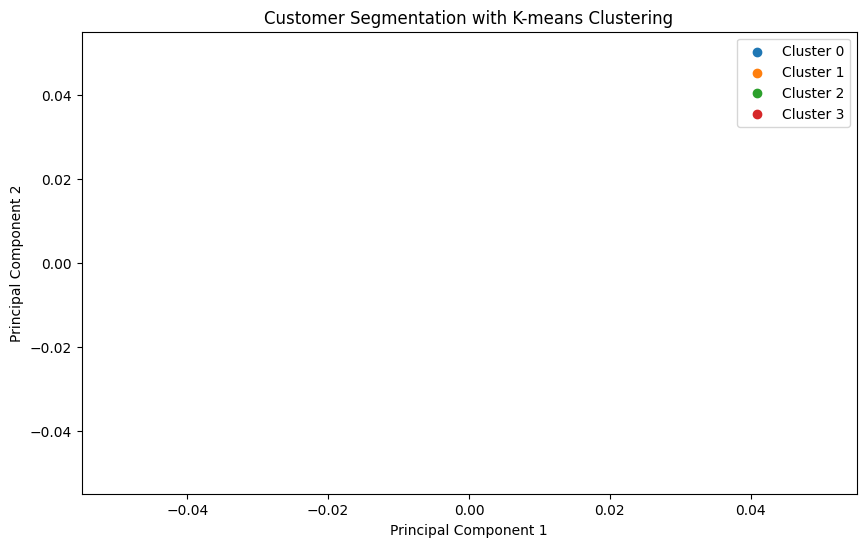

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'scaled_array' is the scaled version of your data
# If not, you might need to scale 'Cluster2_df_a' before applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(Cluster2_df_a)

# Assuming 'Cluster2_df' is the DataFrame containing the cluster information
cluster_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
cluster_df['Cluster'] = Cluster_df['Cluster']  # Make sure the column name matches

# Plot clusters in 2D space
plt.figure(figsize=(10, 6))
for cluster in range(4):  # Assuming 3 clusters, change this if you have a different number of clusters
    plt.scatter(cluster_df.loc[cluster_df['Cluster'] == cluster, 'PC1'],
                cluster_df.loc[cluster_df['Cluster'] == cluster, 'PC2'],
                label=f'Cluster {cluster}')

plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



Made a plot of the average median salary of the jobs for the to 20 cities/locations with the most jobs in our filtered data

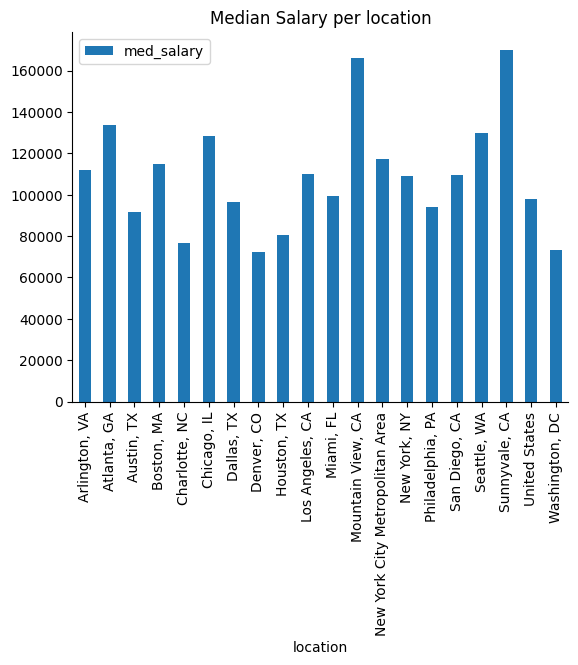

In [ ]:
from matplotlib import pyplot as plt
top_locations = filtered_Y_df['location'].value_counts().nlargest(20).index
filtered_top_locations = filtered_Y_df[filtered_Y_df['location'].isin(top_locations)]
median_salary_per_location = filtered_top_locations.groupby('location')['med_salary'].mean().reset_index()
median_salary_per_location.plot(kind='bar', x='location', y='med_salary',title='Median Salary per location')
plt.gca().spines[['top', 'right',]].set_visible(False)

Noteable points were:
About 13.3% of the available opportunities are Contract work
About 16 % of available are accommodating of a fully remote work
About 24% of jobs are open to sponsorship for the foreign students

In [ ]:
value_counts=Entry_level_jobs['formatted_work_type'].value_counts()
value_counts

In [ ]:
value_counts=Entry_level_jobs['formatted_experience_level'].value_counts()
value_counts

In [ ]:
value_counts=Entry_level_jobs['remote_allowed'].value_counts()
value_counts

The above report shows that about 16% of jobs allow fullyremote working

In [ ]:
value_counts=Entry_level_jobs['sponsored'].value_counts()
value_counts

The above report shows about 24% of the jobs accommodate for sponsorship which we include as it might be a curiosity for international students.

In [ ]:
Entry_level_jobs